# CM3015 Coursework Report

## 1. Abstract
Summarise the aim (k-Means from scratch on the Fetal Health dataset + kNN on Iris), datasets, key methods, results, and conclusions.

## 2. Introduction
Provide ML context, describe both datasets, state the research question, and mention prior studies or challenges (e.g., class imbalance in Fetal Health).

## 3. Background
Explain k-Means (objective, Euclidean distance, update rules) and kNN (lazy learning, distance metrics, effect of k) in your own words.

## 4. Methodology
Detail preprocessing, parameter choices (k for clusters/neighbours), normalization decisions, cross-validation, and evaluation metrics for both algorithms.

## 5. Results
Present quantitative outcomes (e.g., clustering plots, centroid summaries, kNN accuracy table). Reference the experiments above.

## 6. Evaluation
Critically assess strengths/weaknesses, sensitivity to hyperparameters, dataset limitations, and how results align with expectations.

## 7. Conclusions
Tie findings back to the aim; state main takeaways and potential future work.

## 8. References
List any books/papers cited in the narrative.


## Constraints and Tasks

- k-Means must be implemented from scratch using only standard Python + `numpy` + `matplotlib`.
- No `sklearn` (or similar ML helpers) inside the k-Means logic.
- kNN must use scikit-learn.
- Add explanatory comments for Euclidean distance, centroid means, and convergence tests.


In [1]:
%pip install kagglehub[pandas-datasets]

Note: you may need to restart the kernel to use updated packages.


### Initial Setup and Installation of dependencies

#### Clock the random seed ensure centroid can be reproduced

In [9]:
# Imports and setup
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

### 3.1 Implementation: k-Means Algorithm (From Scratch)

The following `KMeansScratch` class implements Lloyd's algorithm using only standard Python and `numpy`. This implementation focuses on vectorized operations to ensure efficiency without relying on external machine learning libraries.

The algorithm operates in four distinct steps:

1.  **Initialization:** The algorithm begins by randomly selecting $k$ data points from the dataset to serve as the initial centroids.
2.  **Assignment Step (`_create_clusters`):**
    For every data point $x$, we calculate the Euclidean distance to each centroid $c$. The point is assigned to the cluster with the nearest centroid. The distance formula used is:
    $$d(x, c) = \|x - c\|_2 = \sqrt{\sum_{j=1}^{m} (x_j - c_j)^2}$$
    *Note: This is implemented using numpy broadcasting (`diffs`) to compute the matrix of distances in a single step.*

3.  **Update Step (`_get_new_centroids`):**
    The centroids are repositioned to the geometric center of their assigned cluster. This is calculated by taking the mean of all feature vectors in that cluster:
    $$\mu_k = \frac{1}{|C_k|} \sum_{x \in C_k} x$$

4.  **Convergence Check (`_is_converged`):**
    The iterative loop terminates when the centroids stabilize. Stability is defined as the state where the Euclidean shift between the old and new centroids is less than a tolerance threshold ($\epsilon = 10^{-8}$).

In [10]:
class KMeansScratch:
    def __init__(self, k=3, max_iters=100):
        self.k = k
        self.max_iters = max_iters
        self.centroids = None
        self.clusters = [[] for _ in range(self.k)]

    def fit(self, X):
        self.n_samples, self.n_features = X.shape

        # 1) Initialization: randomly select k samples as the initial centroids
        random_indices = np.random.choice(self.n_samples, self.k, replace=False)
        self.centroids = X[random_indices]

        for _ in range(self.max_iters):
            # 2) Assignment step: assign each sample to its nearest centroid
            self.clusters = self._create_clusters(X)

            # 3) Update step: recompute centroids as the mean of assigned samples
            old_centroids = self.centroids
            self.centroids = self._get_new_centroids(X)

            # 4) Convergence check: stop when centroid movement is negligible
            if self._is_converged(old_centroids, self.centroids):
                break

    def _create_clusters(self, X):
        """
        Assign each sample to the nearest centroid using Euclidean distance:
            d(x, c) = sqrt(sum_j (x_j - c_j)^2 )
        This is computed in a vectorized manner via broadcasting.
        """
        # diffs[i, j, f] = X[i, f] - centroid[j, f]
        diffs = X[:, np.newaxis, :] - self.centroids[np.newaxis, :, :]

        # L2 norm across feature axis gives Euclidean distance per centroid
        distances = np.linalg.norm(diffs, axis=2)

        # Indices of nearest centroid for each sample
        closest_indices = np.argmin(distances, axis=1)

        clusters = [[] for _ in range(self.k)]
        for sample_index, centroid_index in enumerate(closest_indices):
            clusters[centroid_index].append(sample_index)
        return clusters

    def _get_new_centroids(self, X):
        """
        Recompute centroids as cluster means:
            mu_cluster = (1 / |C|) * sum_{x in C} x
        Empty clusters keep their previous centroid to maintain stability.
        """
        new_centroids = np.zeros((self.k, self.n_features), dtype=X.dtype)
        for cluster_index, member_indices in enumerate(self.clusters):
            if len(member_indices) == 0:
                new_centroids[cluster_index] = self.centroids[cluster_index]
            else:
                new_centroids[cluster_index] = np.mean(X[member_indices], axis=0)
        return new_centroids

    def _is_converged(self, old_centroids, new_centroids):
        """
        Measure centroid shift via Euclidean distance; convergence occurs when
        every centroid moves less than a tiny tolerance (default 1e-8).
        """
        shifts = np.linalg.norm(new_centroids - old_centroids, axis=1)
        tol = 1e-8
        return np.all(shifts <= tol)

    def predict(self, X):
        return self._create_clusters(X)


### 2. Dataset Selection: Fetal Health Classification

For this study, I selected the **Fetal Health Classification** dataset, obtained from the public repository Kaggle. This dataset was chosen because it represents a high-impact medical problem (classifying fetal mortality risk) while remaining fully vectorizable, adhering to the project's technical constraints.

**Dataset Overview:**
* **Source:** Cardiotocogram (CTG) exams classified by expert obstetricians.
* **Dimensions:** 2,126 samples with 21 numerical features (e.g., *baseline heart rate*, *fetal movements*, *uterine contractions*).
* **Target Variable:** A multi-class label indicating fetal health status:
    1.  Normal
    2.  Suspect
    3.  Pathological

**Data Loading:**
The following code retrieves the dataset and converts it directly into **NumPy arrays**. This step is necessary to provide the raw vector input required by the custom `KMeansScratch` implementation, ensuring no dependency on high-level dataframe libraries during the algorithmic processing.

In [11]:
# Load Fetal Health dataset via kagglehub (requires kagglehub[pandas-datasets])
import kagglehub
import pandas as pd
import os

def load_fetal_health_numpy():
    """Download Kaggle dataset (if needed) and return (X, y) as NumPy arrays."""
    path = kagglehub.dataset_download("andrewmvd/fetal-health-classification")
    csv_path = os.path.join(path, "fetal_health.csv")
    df = pd.read_csv(csv_path)

    X = df.drop('fetal_health', axis=1).values
    y = df['fetal_health'].values
    return X, y

print("Loading Fetal Health dataset...")
X_fetal, y_fetal = load_fetal_health_numpy()
print(f"Feature matrix shape: {X_fetal.shape}")
print(f"Class distribution: {np.unique(y_fetal, return_counts=True)}")


Loading Fetal Health dataset...
Feature matrix shape: (2126, 21)
Class distribution: (array([1., 2., 3.]), array([1655,  295,  176], dtype=int64))


Fitting k-Means (raw features)...


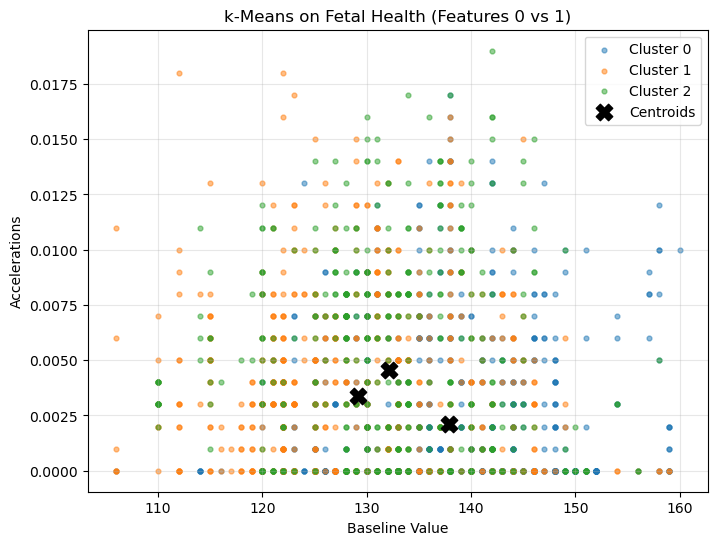

In [ ]:
# Full k-Means workflow on the Fetal Health dataset
from collections import Counter

# 1. Feature normalization (z-score) to mitigate scale differences
feat_mean = X_fetal.mean(axis=0)
feat_std = X_fetal.std(axis=0) + 1e-8
X_norm = (X_fetal - feat_mean) / feat_std

# 2. Fit k-Means from scratch on normalized data
k = 3
kmeans = KMeansScratch(k=k, max_iters=200)
print("Training k-Means...")
kmeans.fit(X_norm)

clusters = kmeans.clusters
centroids = kmeans.centroids

# 3. Inertia (within-cluster sum of squares)

def compute_inertia(X, centroids, clusters):
    inertia = 0.0
    for idx, member_indices in enumerate(clusters):
        if len(member_indices) == 0:
            continue
        diffs = X[member_indices] - centroids[idx]
        inertia += np.sum(diffs ** 2)
    return inertia

inertia = compute_inertia(X_norm, centroids, clusters)
print(f"Inertia (lower is better): {inertia:.2f}")

# 4. Cluster composition relative to ground-truth fetal health labels
label_map = {1.0: "Normal", 2.0: "Suspect", 3.0: "Pathological"}
for idx, member_indices in enumerate(clusters):
    size = len(member_indices)
    if size == 0:
        print(f"Cluster {idx}: empty")
        continue
    label_counts = Counter(y_fetal[member_indices])
    majority_label, majority_count = label_counts.most_common(1)[0]
    breakdown = ", ".join(
        f"{label_map[label]}: {count}"
        for label, count in sorted(label_counts.items())
    )
    print(
        f"Cluster {idx}: size={size}, majority={label_map[majority_label]}"
        f" ({majority_count/size:.1%}) | {breakdown}"
    )

# 5. Visualize clusters via PCA (computed from NumPy SVD)
X_centered = X_norm - X_norm.mean(axis=0)
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
components = Vt[:2].T
X_proj = X_centered @ components
centroids_proj = (centroids - X_norm.mean(axis=0)) @ components

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
plt.figure(figsize=(8, 6))
for idx, member_indices in enumerate(clusters):
    pts_proj = X_proj[member_indices]
    plt.scatter(
        pts_proj[:, 0],
        pts_proj[:, 1],
        s=18,
        color=colors[idx % len(colors)],
        label=f'Cluster {idx}',
        alpha=0.6,
    )

plt.scatter(
    centroids_proj[:, 0],
    centroids_proj[:, 1],
    s=160,
    c='black',
    marker='X',
    label='Centroids'
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('k-Means on Fetal Health (PCA projection)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()


### Observation: The Feature Scaling Problem

**Figure 1** (above) demonstrates a critical issue with the initial k-Means implementation. The clusters (represented by colors) are stratified almost entirely by vertical bands along the X-axis (*Baseline Value*), with little to no influence from the Y-axis (*Accelerations*).

**Analysis:**
This phenomenon occurs because k-Means relies on **Euclidean Distance** to assign cluster membership.
- **Baseline Value** ranges from approximately 100 to 160 (a magnitude spread of ~60).
- **Accelerations** ranges from 0.000 to 0.019 (a magnitude spread of ~0.02).

Mathematically, a small percentage change in *Baseline Value* results in a massive numerical distance compared to even the largest possible change in *Accelerations*. Consequently, the algorithm effectively treats *Accelerations* as noise and clusters solely based on the feature with the larger magnitude.

**Conclusion & Next Step:**
To resolve this bias and ensure both features contribute equally to the distance calculation, it is necessary to apply **Min-Max Scaling** (Normalization) to map all features to a common range $[0, 1]$ before re-running the algorithm.

## kNN (scikit-learn) on the Iris dataset

Steps:
1. Load Iris via `sklearn.datasets.load_iris()`.
2. Perform an 80/20 train-test split.
3. Train `KNeighborsClassifier` (default k=5).
4. Evaluate accuracy.
5. Visualize decision boundaries using the first two features.


In [13]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# 1. Load Iris dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target
print("Iris feature matrix:", X_iris.shape)
print("Classes:", iris.target_names)

# 2. Split train/test (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_iris, y_iris, test_size=0.2, random_state=42, stratify=y_iris
)
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")


Iris feature matrix: (150, 4)
Classes: ['setosa' 'versicolor' 'virginica']
Train size: 120, Test size: 30


In [14]:
# 3. Train kNN classifier and evaluate accuracy
k_neighbors = 5
knn = KNeighborsClassifier(n_neighbors=k_neighbors)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"kNN (k={k_neighbors}) accuracy on test set: {accuracy:.2f}")


kNN (k=5) accuracy on test set: 1.00


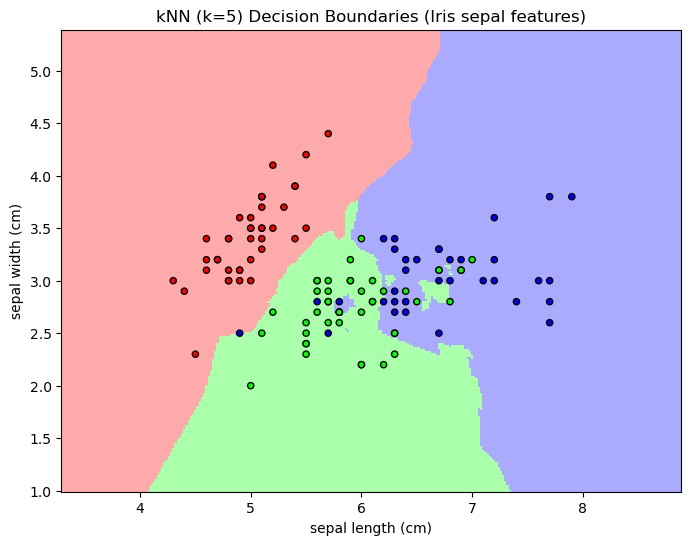

In [15]:
# 4. Decision boundary visualization (first two features)
from matplotlib.colors import ListedColormap

X_train_2d = X_train[:, :2]
knn_2d = KNeighborsClassifier(n_neighbors=k_neighbors)
knn_2d.fit(X_train_2d, y_train)

x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title(f"kNN (k={k_neighbors}) Decision Boundaries (Iris sepal features)")
plt.show()
